## Importing stuff

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, TensorDataset

import numpy as np
import math
import datetime 

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LogNorm

import iris
import iris.plot as iplt
import iris.coord_categorisation
#iris.FUTURE.datum_support = True

from FLO_utils import extract_cube_area, add_bounds, __callback_add_forecast_day
from RH_wrt_water import RH_wrt_water_from_cubes

## Define some local functions

In [2]:
def calc_cube_daymean(cube):
    cube_daymean = cube.copy()
    aux_coord_names = [coord.name() for coord in cube.aux_coords]

    if "year" not in aux_coord_names:
        iris.coord_categorisation.add_year(cube, 'time')
        
    if "day_of_year" not in aux_coord_names:   
        iris.coord_categorisation.add_day_of_year(cube, 'time')
        
    cube_daymean = cube.aggregated_by(['year', 'day_of_year'], iris.analysis.MEAN)
    
    return cube_daymean

## Define some dict and path

In [3]:
NUAQ_NAME_2_SHORT = {
    "NUC_SOL_N_CONCENTRATION"  : "NUC_SOL_NUMBER",
    "NUC_SOL_SU_CONCENTRATION" : "NUC_SOL_H2SO4",
    "NUC_SOL_OM_CONCENTRATION" : "NUC_SOL_OM",
    "AIT_SOL_N_CONCENTRATION"  : "AIT_SOL_NUMBER",
    "AIT_SOL_SU_CONCENTRATION" : "AIT_SOL_H2SO4",
    "AIT_SOL_BC_CONCENTRATION" : "AIT_SOL_BC",
    "AIT_SOL_OM_CONCENTRATION" : "AIT_SOL_OM",
    "AIT_SOL_NH_CONCENTRATION" : "AIT_SOL_NH4",
    "AIT_SOL_NT_CONCENTRATION" : "AIT_SOL_NO3",
    "ACC_SOL_N_CONCENTRATION"  : "ACC_SOL_NUMBER",
    "ACC_SOL_SU_CONCENTRATION" : "ACC_SOL_H2SO4",
    "ACC_SOL_SS_CONCENTRATION" : "ACC_SOL_SS",
    "ACC_SOL_BC_CONCENTRATION" : "ACC_SOL_BC",
    "ACC_SOL_OM_CONCENTRATION" : "ACC_SOL_OM",
    "ACC_SOL_NH_CONCENTRATION" : "ACC_SOL_NH4",
    "ACC_SOL_NT_CONCENTRATION" : "ACC_SOL_NO3",
    "COR_SOL_N_CONCENTRATION"  : "COA_SOL_NUMBER",
    "COR_SOL_SU_CONCENTRATION" : "COA_SOL_H2SO4",
    "COR_SOL_BC_CONCENTRATION" : "COA_SOL_BC",
    "COR_SOL_OM_CONCENTRATION" : "COA_SOL_OM",
    "COR_SOL_SS_CONCENTRATION" : "COA_SOL_SS",
    "COR_SOL_NH_CONCENTRATION" : "COA_SOL_NH4",
    "COR_SOL_NT_CONCENTRATION" : "COA_SOL_NO3",
    "AIT_INS_N_CONCENTRATION"  : "AIT_INS_NUMBER",
    "AIT_INS_BC_CONCENTRATION" : "AIT_INS_BC",
    "AIT_INS_OM_CONCENTRATION" : "AIT_INS_OM",
    "SURFAREA_CONCENTRATION"   : "SURF_AREA",     # FOR WHAT MODE ???
}

NUAQ_SHORT_2_NAME = {val: key for key, val in NUAQ_NAME_2_SHORT.items()}

nameid = 'da544'
NUAQ_PATH = "/data/users/fmalavel/NU-AQ/Code_review/" + \
            "PULL_REQUEST_0173/model_outputs/u-" + nameid

## Loading NUAQ Data

In [4]:
NUAQ_files = "20190412T0000Z_Fields_grid_nc_C1_*"
NUAQ_files = "2019*"

#loading all data in a cubelist
all_cubes = iris.load(NUAQ_PATH + '/' + NUAQ_files + ".nc")#, time_constraint)
print(all_cubes)

start_datetime=datetime.datetime(2019,4,11,0)
end_datetime=datetime.datetime(2019,4,13,0)

time_constraint = iris.Constraint(
    time=lambda c: c.point >= start_datetime
    and c.point <= end_datetime)

short_2_read = [
    'AIT_SOL_NUMBER',
    'AIT_SOL_H2SO4',
    'AIT_SOL_BC',
    'AIT_SOL_OM',
    'AIT_SOL_NO3',
    'AIT_SOL_NH4',
    'ACC_SOL_NUMBER',
    'ACC_SOL_H2SO4',
    'ACC_SOL_BC',
    'ACC_SOL_OM',
    'ACC_SOL_SS',
    'ACC_SOL_NO3',
    'ACC_SOL_NH4',
    'COA_SOL_NUMBER',
    'COA_SOL_H2SO4',
    'COA_SOL_BC',
    'COA_SOL_OM',
    'COA_SOL_SS',
    'COA_SOL_NO3',
    'COA_SOL_NH4',
    'AIT_INS_NUMBER',
    'AIT_INS_BC',
    'AIT_INS_OM',
]

NUAQ_cubelist = iris.cube.CubeList()
keys = [ NUAQ_SHORT_2_NAME[x] for x in short_2_read]

#for short in short_2_read:
for i, key in enumerate(keys):
    name_constraint =  iris.Constraint(key)
    cube = all_cubes.extract_cube(name_constraint & time_constraint)
    print(cube)
    NUAQ_cubelist.append(cube)

print(NUAQ_cubelist)

/var/tmp/ipykernel_7026/2621912468.py:5: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  all_cubes = iris.load(NUAQ_PATH + '/' + NUAQ_files + ".nc")#, time_constraint)
/var/tmp/ipykernel_7026/2621912468.py:5: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  all_cubes = iris.load(NUAQ_PATH + '/' + NUAQ_files + ".nc")#, time_constraint)
/var/tmp/ipykernel_7026/2621912468.py:5: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  all_cubes = iris.load(NUAQ_PATH + '/' + NUAQ_files + ".nc")

0: SO2_CONCENTRATION / (g / m^3)       (time: 24; latitude: 40; longitude: 46)
1: ACC_SOL_SU_CONCENTRATION / (g / m^3) (time: 24; latitude: 40; longitude: 46)
2: COR_SOL_SU_CONCENTRATION / (g / m^3) (time: 24; latitude: 40; longitude: 46)
3: COR_SOL_SS_CONCENTRATION / (g / m^3) (time: 24; latitude: 40; longitude: 46)
4: SURFAREA_CONCENTRATION / (g / m^3)  (time: 24; latitude: 40; longitude: 46)
5: ACC_SOL_SS_CONCENTRATION / (g / m^3) (time: 24; latitude: 40; longitude: 46)
6: COR_SOL_NH_CONCENTRATION / (g / m^3) (time: 24; latitude: 40; longitude: 46)
7: AIT_SOL_NH_CONCENTRATION / (g / m^3) (time: 24; latitude: 40; longitude: 46)
8: COR_SOL_NN_CONCENTRATION / (g / m^3) (time: 24; latitude: 40; longitude: 46)
9: ACC_SOL_BC_CONCENTRATION / (g / m^3) (time: 24; latitude: 40; longitude: 46)
10: NO2_CONCENTRATION / (g / m^3)       (time: 24; latitude: 40; longitude: 46)
11: H2O2_CONCENTRATION / (g / m^3)      (time: 24; latitude: 40; longitude: 46)
12: ACC_SOL_N_CONCENTRATION / (g / m^3) (t

In [5]:
# Loading single cubes

# Mode MMRs
ait_ins_om = NUAQ_cubelist.extract_cube(iris.Constraint(NUAQ_SHORT_2_NAME["AIT_INS_OM"]))
ait_ins_bc = NUAQ_cubelist.extract_cube(iris.Constraint(NUAQ_SHORT_2_NAME["AIT_INS_BC"]))
ait_sol_so4 = NUAQ_cubelist.extract_cube(iris.Constraint(NUAQ_SHORT_2_NAME["AIT_SOL_H2SO4"]))
ait_sol_om = NUAQ_cubelist.extract_cube(iris.Constraint(NUAQ_SHORT_2_NAME["AIT_SOL_OM"]))
ait_sol_bc = NUAQ_cubelist.extract_cube(iris.Constraint(NUAQ_SHORT_2_NAME["AIT_SOL_BC"]))
ait_sol_no3 = NUAQ_cubelist.extract_cube(iris.Constraint(NUAQ_SHORT_2_NAME["AIT_SOL_NO3"]))
ait_sol_nh4 = NUAQ_cubelist.extract_cube(iris.Constraint(NUAQ_SHORT_2_NAME["AIT_SOL_NH4"]))
acc_sol_so4 = NUAQ_cubelist.extract_cube(iris.Constraint(NUAQ_SHORT_2_NAME["ACC_SOL_H2SO4"]))
acc_sol_bc = NUAQ_cubelist.extract_cube(iris.Constraint(NUAQ_SHORT_2_NAME["ACC_SOL_BC"]))
acc_sol_om = NUAQ_cubelist.extract_cube(iris.Constraint(NUAQ_SHORT_2_NAME["ACC_SOL_OM"]))
acc_sol_ss = NUAQ_cubelist.extract_cube(iris.Constraint(NUAQ_SHORT_2_NAME["ACC_SOL_SS"]))
acc_sol_no3 = NUAQ_cubelist.extract_cube(iris.Constraint(NUAQ_SHORT_2_NAME["ACC_SOL_NO3"]))
acc_sol_nh4 = NUAQ_cubelist.extract_cube(iris.Constraint(NUAQ_SHORT_2_NAME["ACC_SOL_NH4"]))
coa_sol_so4 = NUAQ_cubelist.extract_cube(iris.Constraint(NUAQ_SHORT_2_NAME["COA_SOL_H2SO4"]))
coa_sol_bc = NUAQ_cubelist.extract_cube(iris.Constraint(NUAQ_SHORT_2_NAME["COA_SOL_BC"]))
coa_sol_om = NUAQ_cubelist.extract_cube(iris.Constraint(NUAQ_SHORT_2_NAME["COA_SOL_OM"]))
coa_sol_ss = NUAQ_cubelist.extract_cube(iris.Constraint(NUAQ_SHORT_2_NAME["COA_SOL_SS"]))
coa_sol_no3 = NUAQ_cubelist.extract_cube(iris.Constraint(NUAQ_SHORT_2_NAME["COA_SOL_NO3"]))
coa_sol_nh4 = NUAQ_cubelist.extract_cube(iris.Constraint(NUAQ_SHORT_2_NAME["COA_SOL_NH4"]))

# Mode Numbers
ait_sol_number = NUAQ_cubelist.extract_cube(iris.Constraint(NUAQ_SHORT_2_NAME["AIT_SOL_NUMBER"]))
acc_sol_number = NUAQ_cubelist.extract_cube(iris.Constraint(NUAQ_SHORT_2_NAME["ACC_SOL_NUMBER"]))
coa_sol_number = NUAQ_cubelist.extract_cube(iris.Constraint(NUAQ_SHORT_2_NAME["COA_SOL_NUMBER"]))
ait_ins_number = NUAQ_cubelist.extract_cube(iris.Constraint(NUAQ_SHORT_2_NAME["AIT_INS_NUMBER"]))

print(ait_sol_number)

AIT_SOL_N_CONCENTRATION / (g / m^3) (time: 24; latitude: 40; longitude: 46)
    Dimension coordinates:
        time                             x             -              -
        latitude                         -             x              -
        longitude                        -             -              x
    Scalar coordinates:
        forecast_reference_time     2019-04-09 00:00:00
        height                      50.0 m, bound=(0.0, 100.0) m
    Cell methods:
        mean                        time
        mean                        height
    Attributes:
        Conventions                 'CF-1.8'
        comment                     'none'
        end_of_release              'infinity'
        field_name                  'Unnamed Field Req 18'
        history                     'NAME 20/08/2024 12:20:49.394 UTC'
        horizontal_av_int_info      'No horizontal averaging'
        institution                 'NA'
        met_data                    'NWP Flow.Regi

## Process cubes

In [6]:
# Combine Mode MMRs into one cube
modes_ait = (ait_sol_number).copy()
modes_acc = (ait_sol_number).copy()
modes_coa = (ait_sol_number).copy()
modes_all = (ait_sol_number).copy()

modes_ait.data = modes_ait.data * 0.0
modes_acc.data = modes_acc.data * 0.0
modes_coa.data = modes_coa.data * 0.0
modes_all.data = modes_all.data * 0.0

rho_air = 1.25  # assumes pho_air is 1.25 kg/m3
kgkg_to_ugm3 = rho_air * 1e9     # convert stuff/vol (g.aerosol / m3) to concentration (kg.aerosol / m3) 
g_to_kg = 1e-3
m3_to_cm3 = 1e6

modes_ait.data = \
        (ait_ins_bc.data + ait_ins_om.data + \
        ait_sol_so4.data + ait_sol_bc.data + \
        ait_sol_om.data + ait_sol_no3.data + \
        ait_sol_nh4.data) * kgkg_to_ugm3 * g_to_kg

modes_acc.data = \
        (acc_sol_so4.data + acc_sol_bc.data + \
        acc_sol_om.data + acc_sol_ss.data + \
        acc_sol_no3.data + acc_sol_nh4.data) * kgkg_to_ugm3 * g_to_kg

modes_coa.data = \
        (coa_sol_so4.data + coa_sol_bc.data + \
        coa_sol_om.data + coa_sol_ss.data + \
        coa_sol_no3.data + coa_sol_nh4.data) * kgkg_to_ugm3 * g_to_kg

modes_all.data = \
        (ait_ins_bc.data + ait_ins_om.data + \
        ait_sol_so4.data + ait_sol_bc.data + \
        ait_sol_om.data + ait_sol_no3.data + \
        ait_sol_nh4.data + \
        acc_sol_so4.data + acc_sol_bc.data + \
        acc_sol_om.data + acc_sol_ss.data + \
        acc_sol_no3.data + acc_sol_nh4.data + \
        coa_sol_so4.data + coa_sol_bc.data + \
        coa_sol_om.data + coa_sol_ss.data + \
        coa_sol_no3.data + coa_sol_nh4.data) * kgkg_to_ugm3 * g_to_kg

# Convert the NMR expressed as g/m3 to number concentrations (#/cm3). 
# Number Tracers are number mixing ratio (mol/mol) but
# NAME currently assumes these are emited as MMR (i.e. kg/m2/s) 
# hence desbribing the outputs as g/m3.
# Here we convert from g/m3 to number/cm3 

boltzmann       = 1.380649e-23
aird = 1013e2 / 282 / boltzmann

ait_sol_number.data = ait_sol_number.data * g_to_kg #* aird / m3_to_cm3
acc_sol_number.data = acc_sol_number.data * g_to_kg #* aird / m3_to_cm3
coa_sol_number.data = coa_sol_number.data * g_to_kg #* aird / m3_to_cm3
ait_ins_number.data = ait_ins_number.data * g_to_kg #* aird / m3_to_cm3
#ait_sol_number.units = "cm-3"
#ait_sol_number.units = "cm-3"
#coa_sol_number.units = "cm-3"
#ait_ins_number.units = "cm-3"
ait_sol_number.units = "1"
acc_sol_number.units = "1"
coa_sol_number.units = "1"
ait_ins_number.units = "1"

#add bounds and remove domain edges
#add_bounds(modes_ait)
#add_bounds(modes_acc)
#add_bounds(modes_coa)
#add_bounds(modes_all)
#add_bounds(ait_sol_number)
#add_bounds(acc_sol_number)
#add_bounds(coa_sol_number)
#add_bounds(ait_ins_number)

extract_modes_ait = calc_cube_daymean(modes_ait)
extract_modes_acc = calc_cube_daymean(modes_acc)
extract_modes_coa = calc_cube_daymean(modes_coa)
extract_modes_all = calc_cube_daymean(modes_all)
extract_ait_sol_number = calc_cube_daymean(ait_sol_number)
extract_acc_sol_number = calc_cube_daymean(ait_sol_number)
extract_coa_sol_number = calc_cube_daymean(coa_sol_number)
extract_ait_ins_number = calc_cube_daymean(ait_ins_number)

print(f"\n{extract_ait_ins_number}")
print(f"\n{ait_ins_number}")


AIT_INS_N_CONCENTRATION / (1)       (time: 2; latitude: 40; longitude: 46)
    Dimension coordinates:
        time                             x            -              -
        latitude                         -            x              -
        longitude                        -            -              x
    Auxiliary coordinates:
        day_of_year                      x            -              -
        year                             x            -              -
    Scalar coordinates:
        forecast_reference_time     2019-04-09 00:00:00
        height                      50.0 m, bound=(0.0, 100.0) m
    Cell methods:
        mean                        time
        mean                        height
        mean                        day_of_year, year
    Attributes:
        Conventions                 'CF-1.8'
        comment                     'none'
        end_of_release              'infinity'
        field_name                  'Unnamed Field Req 39'
    

In [13]:
mean_ait_ins = np.mean(ait_ins_number.data)
print(mean_ait_ins)
mean_ait_sol = np.mean(ait_sol_number.data)
print(mean_ait_sol)
mean_acc_sol = np.mean(acc_sol_number.data)
print(mean_acc_sol)

mean_modes_ait = np.mean(modes_ait.data)
print(mean_modes_ait)
mean_modes_acc = np.mean(modes_acc.data)
print(mean_modes_acc)
mean_modes_all = np.mean(modes_all.data)
print(mean_modes_all)

2.670506e-15
1.31118e-16
4.913568e-17
2.3563688
4.753232
7.1730237


## Initiate NN model

In [7]:
# Define the model
class PM_Net(nn.Module):
    def __init__(self):
        super(PM_Net, self).__init__()
        #self.fc1 = nn.Linear(7, 100)
        self.fc1 = nn.Linear(7, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialise model
model = PM_Net()

# Loading the model
model.load_state_dict(torch.load("PM2p5_model.NN"))#, weights_only=True))
model.eval()

PM_Net(
  (fc1): Linear(in_features=7, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)

## Loading Trained PM Model

In [8]:
#NN_pm2p5dry = extract_ait_ins_number.copy()
#NN_pm2p5wet = extract_ait_ins_number.copy()
#NN_pm10dry = extract_ait_ins_number.copy()
#NN_pm10wet = extract_ait_ins_number.copy()

NN_pm2p5dry = ait_ins_number.copy()
#NN_pm2p5wet = ait_ins_number.copy()
#NN_pm10dry = ait_ins_number.copy()
#NN_pm10wet = ait_ins_number.copy()

dt, dx, dy = NN_pm2p5dry.data.shape
print(f"{NN_pm2p5dry.data.shape}")

for i in range(dt):
    for j in range(dx):
        for k in range(dy):
            # Define the features/predictors to be used:
            #x1_1D = extract_modes_ait.data[i,j,k].reshape(-1, 1)
            #x2_1D = extract_modes_acc.data[i,j,k].reshape(-1, 1)
            #x3_1D = extract_modes_coa.data[i,j,k].reshape(-1, 1)
  
            #x5_1D = extract_ait_ins_number.data[i,j,k].reshape(-1, 1)
            #x6_1D = extract_coa_sol_number.data[i,j,k].reshape(-1, 1)
            #x7_1D = extract_acc_sol_number.data[i,j,k].reshape(-1, 1)
            #x8_1D = extract_ait_sol_number.data[i,j,k].reshape(-1, 1)
            
            x1_1D = modes_ait.data[i,j,k].reshape(-1, 1)
            x2_1D = modes_acc.data[i,j,k].reshape(-1, 1)
            x3_1D = modes_coa.data[i,j,k].reshape(-1, 1)
  
            x5_1D = ait_ins_number.data[i,j,k].reshape(-1, 1)
            x6_1D = coa_sol_number.data[i,j,k].reshape(-1, 1)
            x7_1D = acc_sol_number.data[i,j,k].reshape(-1, 1)
            x8_1D = ait_sol_number.data[i,j,k].reshape(-1, 1)
            
            x_1D = np.hstack((x1_1D, x2_1D, x3_1D, x5_1D, x6_1D, x7_1D, x8_1D))
            x_array = torch.tensor(x_1D, dtype=torch.float32).unsqueeze(1)
            #print(f"x_array = {x_array}")
            
            with torch.no_grad():
                NN_pm2p5dry.data[i,j,k] = model(x_array).detach().numpy()
                #NN_pm2p5wet.data[i,j,k] = model(x_array).detach().numpy()
                #NN_pm10dry.data[i,j,k] = model(x_array).detach().numpy()
                #NN_pm10wet.data[i,j,k] = model(x_array).detach().numpy()
                #print(f"{NN_pm2p5dry.data[i,j,k]} / {extract_pm2p5dry.data[i,j,k]}")

(24, 40, 46)


## Plot AQUM PM diag vs NN estimates

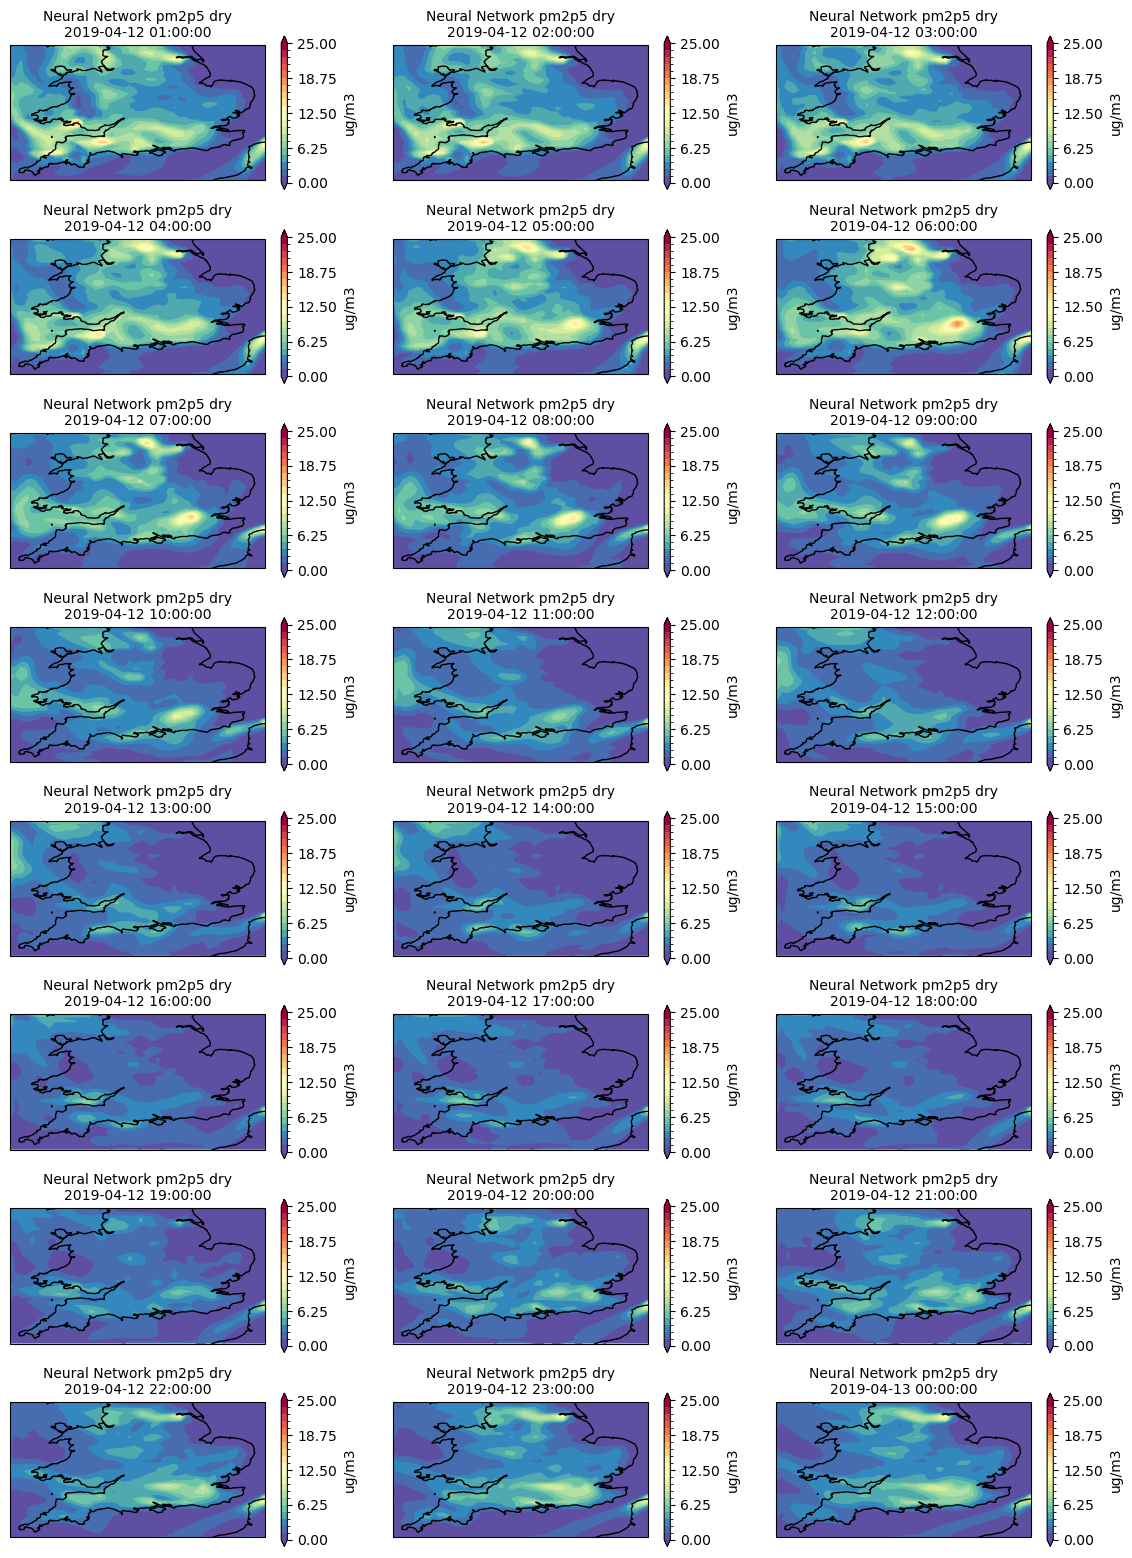

In [9]:
time_coord = modes_ait.coord("time")
nt = len(time_coord.points)

fig = plt.figure(figsize=(14,nt*2.5), dpi=100)

pad = 0.05
sh = 0.95
asp = 25

for n in range(nt):
    string_time = time_coord.units.num2date(time_coord.points[n])
    #print(f"{string_time}")
    
    time_constraint = iris.Constraint(time=lambda t: t.point == time_coord.units.num2date(time_coord.points[n]))
    AQUM_cube = modes_ait.extract(time_constraint)
    NN_cube = modes_ait.extract(time_constraint)

    
    # PM Neural Network
    #   Fig 1   #
    plt.subplot(nt, 3, n+1)
     
    cmap = plt.get_cmap("Spectral")
    cmap_r = cmap.reversed()
    cmap = cmap_r
    
    cb_min=0
    cb_max=25
    
    levels = np.linspace(cb_min, cb_max, 21)
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=False)
    tick_lvl = levels[0::5]
    cb_label_str = 'ug/m3'
    
    iplt.contourf(NN_cube,
                  levels=levels,
                  cmap=cmap, 
                  norm=norm,
                  extend='both')
    
    plt.colorbar(orientation='vertical',
                 ticks=tick_lvl,
                 # format="%.1e",
                 pad=pad,
                 aspect=asp,
                 shrink=sh).set_label(cb_label_str)
    
    plt.gca().coastlines(resolution='10m')
    plt.title("Neural Network pm2p5 dry" + f"\n{string_time}", fontsize=10, linespacing=1.2)

